In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = '/content/drive/MyDrive/release_in_the_wild'
os.chdir(path)
print("Diretório atual:", os.getcwd())

Diretório atual: /content/drive/MyDrive/release_in_the_wild


Listing files...
Found 19999 real files and 17215 fake files.
Extracting CQCC features...


100%|██████████| 37214/37214 [7:13:04<00:00,  1.43it/s]


CQCC shape: (37214, 40)
Training SVM with CQCC...
Saved SVM: /content/drive/MyDrive/modelos_deepfake/svm_cqcc.pkl

📊 SVM CQCC Evaluation
Accuracy: 0.9844
AUC:      0.9987

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99      4000
        Fake       0.98      0.99      0.98      3443

    accuracy                           0.98      7443
   macro avg       0.98      0.98      0.98      7443
weighted avg       0.98      0.98      0.98      7443



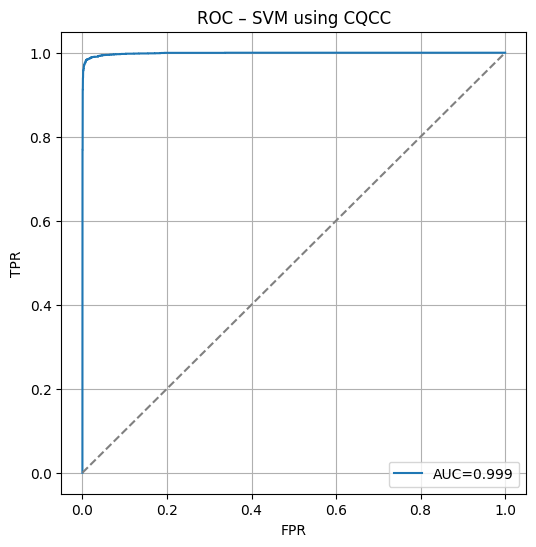

In [5]:
import os
import glob
import random
import numpy as np
import scipy.fft
import librosa
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- CONFIG ----------
DATA_DIR = '/content/drive/MyDrive/release_in_the_wild'
SR = 16000
N_CQCC = 40              # número de coeficientes cepstrais após DCT
BINS_PER_OCTAVE = 96     # resolução fina da CQT
MODEL_DIR = "/content/drive/MyDrive/modelos_deepfake"
os.makedirs(MODEL_DIR, exist_ok=True)
CQCC_SAVE = os.path.join(MODEL_DIR, "svm_cqcc.pkl")
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# ---------- UTILIDADES ----------
def list_audio_files(base_dir, exts=('.wav', '.flac', '.mp3')):
    p_real = os.path.join(base_dir, "real")
    p_fake = os.path.join(base_dir, "fake")

    real_files, fake_files = [], []

    for root, _, files in os.walk(p_real):
        for f in files:
            if f.lower().endswith(exts):
                real_files.append(os.path.join(root, f))

    for root, _, files in os.walk(p_fake):
        for f in files:
            if f.lower().endswith(exts):
                fake_files.append(os.path.join(root, f))

    return real_files, fake_files


def load_audio(path, sr=SR):
    wav, fs = sf.read(path)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if fs != sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=fs, target_sr=sr)
    return wav.astype(np.float32)


# ============================================================
# 1. Função para extrair CQCC
# ============================================================
def extract_cqcc(wave, sr=16000, n_cqcc=40, bins_per_octave=96):
    """
    CQCC = DCT(log(CQT^2))
    CQT → log-power → DCT → coeficientes
    """

    # 1) CQT complex
    CQT = librosa.cqt(
        wave,
        sr=sr,
        hop_length=128,
        fmin=20,
        n_bins=8 * bins_per_octave,
        bins_per_octave=bins_per_octave,
        pad_mode="reflect"     # evita janelas curtas
    )

    # 2) Espectro de potência
    power = np.abs(CQT)**2

    # 3) Log-power
    log_power = np.log(power + 1e-12)

    # 4) DCT → cepstrum
    cqcc = scipy.fft.dct(log_power, axis=0, norm='ortho')

    # 5) Mantém primeiros coeficientes
    cqcc = cqcc[:n_cqcc, :]

    return cqcc


# ============================================================
# 2. Vetor fixo (média temporal)
# ============================================================
def extract_cqcc_mean(wave, sr=16000, n_cqcc=40):
    cq = extract_cqcc(wave, sr=sr, n_cqcc=n_cqcc)
    return np.mean(cq, axis=1)


# ============================================================
# 3. Construindo dataset
# ============================================================
print("Listing files...")
real_files, fake_files = list_audio_files(DATA_DIR)
print(f"Found {len(real_files)} real files and {len(fake_files)} fake files.")

files = [(p, 0) for p in real_files] + [(p, 1) for p in fake_files]
random.shuffle(files)

X, y = [], []

print("Extracting CQCC features...")
for path, lbl in tqdm(files):
    try:
        wav = load_audio(path)
        vec = extract_cqcc_mean(wav)
        X.append(vec)
        y.append(lbl)
    except Exception as e:
        print("Failed on", path, e)

X = np.vstack(X)
y = np.array(y)

print("CQCC shape:", X.shape)


# ============================================================
# 4. Treinamento do SVM
# ============================================================
print("Training SVM with CQCC...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

svm = SVC(kernel="rbf", probability=True, class_weight="balanced",
          random_state=RANDOM_SEED)

svm.fit(X_train, y_train)

# Salvar modelo
joblib.dump(svm, CQCC_SAVE)
print("Saved SVM:", CQCC_SAVE)


# ============================================================
# 5. Avaliação
# ============================================================
svm = joblib.load(CQCC_SAVE)
y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print("\n📊 SVM CQCC Evaluation")
print("===============================")
print(f"Accuracy: {acc:.4f}")
print(f"AUC:      {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))


# ============================================================
# 6. ROC Curve
# ============================================================
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC – SVM using CQCC")
plt.grid(True)
plt.legend()
plt.show()
